<a href="https://colab.research.google.com/github/jnunez03/CppFolder/blob/master/CorevsCK_FreeTrials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import pandas_profiling
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
from pandas import Series, DataFrame
from pylab import *
import statsmodels.api as sm
import matplotlib.style as style
from matplotlib.ticker import MaxNLocator
from matplotlib.font_manager import FontProperties
from scipy import stats
from scipy.stats import norm
from fbprophet import Prophet
import logging

logger = logging.getLogger('pandas_gbq')
logger.propagate = False 
logging.getLogger().disabled = True

q = """
WITH ft_dates as 
(
SELECT
regi_id,
FT_start_date,
FT_end_date,
DATE_TRUNC(FT_start_date,WEEK(MONDAY)) as FT_start_week
FROM `nyt-bigquery-beta-workspace.omalley_amanda.CK_FT`
WHERE FT_start_date BETWEEN '2019-08-01' AND '2019-09-01' 
GROUP BY 1,2,3,4
),

visits as 
(
SELECT
a.regi_id,
b.FT_start_date,
b.FT_end_date,
date(a.last_updated_dt_nyct) as days,
max(date(a.last_updated_dt_nyct)) as LV
FROM `nyt-bigquery-beta-workspace.omalley_amanda.CK_PAY_actives` a 
JOIN ft_dates b ON a.regi_id = CAST(b.regi_id as string)
WHERE last_updated_dt_nyct BETWEEN '2019-08-01' AND '2019-09-29'
GROUP BY 1,2,3,4
),
regi_distinction as (
SELECT 
regi_id,
count(distinct days) as visits,
count(distinct case when DATE_DIFF(LV,FT_start_date,DAY) < 29 then days else null end) as DV
--COUNT(DISTINCT CASE WHEN days <= FT_end_date THEN days else null end) as days_visited
FROM visits
--WHERE DATE_DIFF(LV,FT_start_date,DAY) < 30
group by 1
order by 3 desc 
),
regi as 
    (
SELECT
a.id as regi,
MAX(
CASE WHEN 
LOWER(b.regi_source_name) LIKE '%cooking%' 
OR LOWER(c.regi_interface_name) LIKE '%cooking%' 
OR LOWER(d.regi_platform_name) LIKE '%cooking%'
OR LOWER(r.client_id) LIKE '%cooking%' 
OR LOWER(r.application) LIKE '%cooking%'
THEN "cooking" 
Else "other" END) as regi_source
FROM `nytdata.regi.mv_regi_info` a 
    JOIN `nytdata.regi.mv_regi_source_ref` b
    ON a.regi_source_id = b.regi_source_id
    JOIN `nytdata.regi.mv_regi_interface_ref` c 
    ON a.regi_interface_id = c.regi_interface_id
    JOIN `nytdata.regi.mv_regi_platform_ref` d 
    ON a.regi_platform_id = d.regi_platform_id
FULL OUTER JOIN `nytdata.auth.regi_tracking` r ON a.id = r.regi_id
group by 1 
)
SELECT 
p.regi_id,
p.DV,
MAX(CASE WHEN dssor.regi_source = 'cooking' then  1 ELSE 0 END) as CK,
MAX(CASE WHEN dssor.regi_source = 'other' then 1 ELSE 0 END) AS Core
FROM regi dssor
JOIN regi_distinction p on  cast(dssor.regi as string) = p.regi_id
group by 1,2
"""
# importing the data
df = pd.read_gbq(q,
    project_id = 'nyt-bigquery-beta-workspace',
    dialect='standard')

# Descriptive statistics, data type, data preview 
print(df.describe(), ' \n \n', '*Data Types Below* \n \n', df.dtypes ,' \n \n', df.head(n=6))

                  DV             CK           Core
count  345950.000000  345950.000000  345950.000000
mean        3.112193       0.485119       0.514881
std         3.727931       0.499779       0.499779
min         0.000000       0.000000       0.000000
25%         1.000000       0.000000       0.000000
50%         2.000000       0.000000       1.000000
75%         3.000000       1.000000       1.000000
max        55.000000       1.000000       1.000000  
 
 *Data Types Below* 
 
 regi_id    object
DV          int64
CK          int64
Core        int64
dtype: object  
 
     regi_id  DV  CK  Core
0  73149445   3   0     1
1  71949049   1   0     1
2  72465663   1   0     1
3  74321071   1   0     1
4  88595017   4   0     1
5  94394880   2   0     1


In [0]:
dfcore = df[df['CK'] != 1]
dfck = df[df['Core'] != 1 ]

In [5]:
dfck.head(n=10)

,regi_id,DV,CK,Core
178123,86258202,2,1,0
178124,80492412,12,1,0
178125,78934565,2,1,0
178126,71675508,4,1,0
178127,86362100,2,1,0
178128,90444157,7,1,0
178129,83897778,9,1,0
178130,86983808,1,1,0
178131,89337701,11,1,0
178132,89346644,6,1,0


In [0]:
%matplotlib inline
style.use('fivethirtyeight')
rcParams['figure.figsize'] = 12,8
sb.distplot(dfck.DV)

dfck.describe()

In [0]:
sb.distplot(dfcore.DV)
dfcore.describe()

In [0]:
x1 = df.loc[df.cut=='Ideal', 'depth']
x2 = df.loc[df.cut=='Fair', 'depth']
x3 = df.loc[df.cut=='Good', 'depth']

kwargs = dict(alpha=0.5, bins=100)

plt.hist(x1, **kwargs, color='g', label='Ideal')
plt.hist(x2, **kwargs, color='b', label='Fair')
plt.hist(x3, **kwargs, color='r', label='Good')
plt.gca().set(title='Frequency Histogram of Diamond Depths', ylabel='Frequency')
plt.xlim(50,75)
plt.legend();

In [0]:
sb.countplot(x="DV", data=dfck)

In [0]:
dfcore1 = dfcore[dfcore['DV'] < 29]
dfck1 = dfck[dfck['DV'] < 29]



# Core Regi Free Trial Data

-- Average days visited is 3.05



DV: stands for Days visited. 
Core sourced FTs: 177,817

,DV,CK,Core
count,177817.000000,177817.0,177817.0
mean,3.048780,0.0,1.0
std,3.591175,0.0,0.0
min,0.000000,0.0,1.0
25%,1.000000,0.0,1.0
50%,2.000000,0.0,1.0
75%,3.000000,0.0,1.0
max,28.000000,0.0,1.0


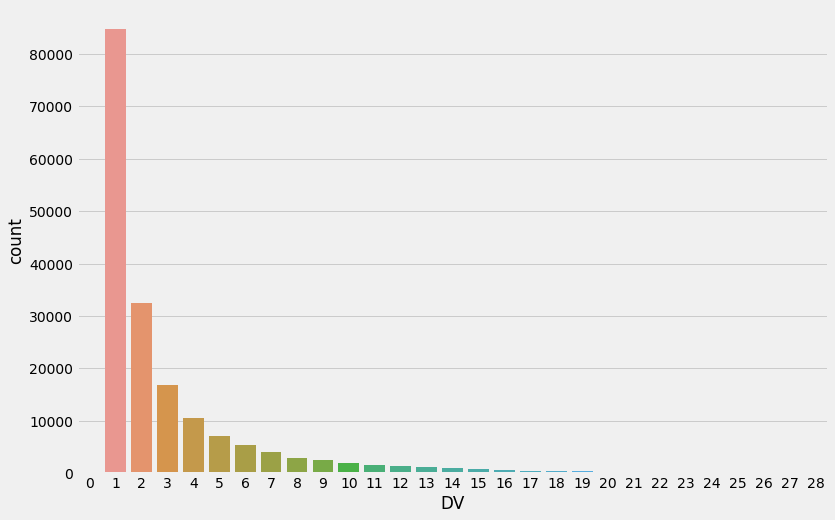

In [11]:
%matplotlib inline
style.use('fivethirtyeight')
rcParams['figure.figsize'] = 12,8
sb.countplot(x="DV", data=dfcore1)
dfcore1.describe()


# Cooking Regi Free Trial Data 

Cooking sourced FTs: 167,666

-- Average days visited is 3.09
-- Less One and Dones than Core!


,DV,CK,Core
count,167666.000000,167666.0,167666.0
mean,3.094193,1.0,0.0
std,3.508462,0.0,0.0
min,0.000000,1.0,0.0
25%,1.000000,1.0,0.0
50%,2.000000,1.0,0.0
75%,4.000000,1.0,0.0
max,28.000000,1.0,0.0


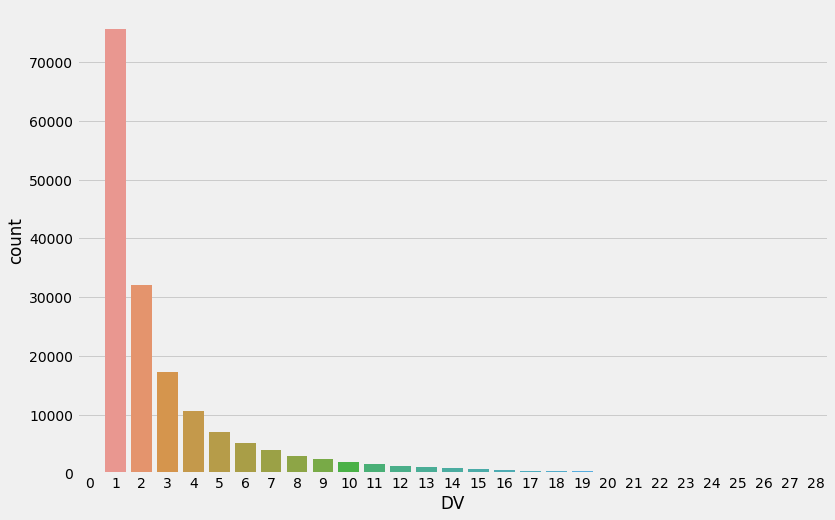

In [12]:
sb.countplot(x="DV", data=dfck1)
dfck1.describe()